## Simple data analysis

Inspired by: Time Series Basics: Exploring Traditional TS, a kaggle kernel by Jagan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Importing data

In [2]:
sales = pd.read_csv('../data/sales_train_v2.csv')

item_cat = pd.read_csv('../data/item_categories.csv')
sub = pd.read_csv("../data/sample_submission.csv")
shops = pd.read_csv("../data/shops.csv")
item = pd.read_csv("../data/items.csv")
test = pd.read_csv("../data/test.csv")

### Converting date column to datetime

In [3]:
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


### Aggregating data per month, with:

- min and max on the date
- average of the item_price
- sum of the sales

In [4]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [5]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

### Analysing item category data

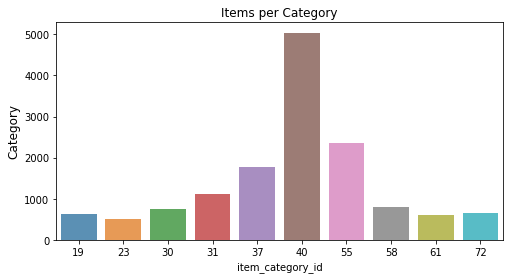

In [6]:
import seaborn as sns

x = item.groupby(['item_category_id']).count()
x = x.sort_values(by = 'item_id', ascending=False)
x = x.iloc[0:10].reset_index()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)
plt.title('Items per Category')
plt.ylabel('# of items', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

### Computing total sales per month as time series

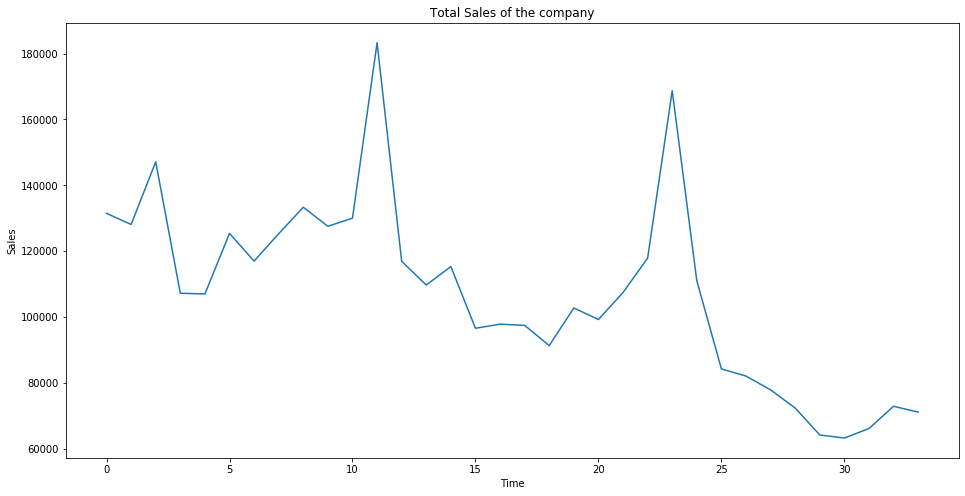

In [7]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

**Quick observation**: As expected, the last months of the year represent the period with the highest number of sales, in other words, the seasonality of the number of sales recur reasonably every year around the same time.

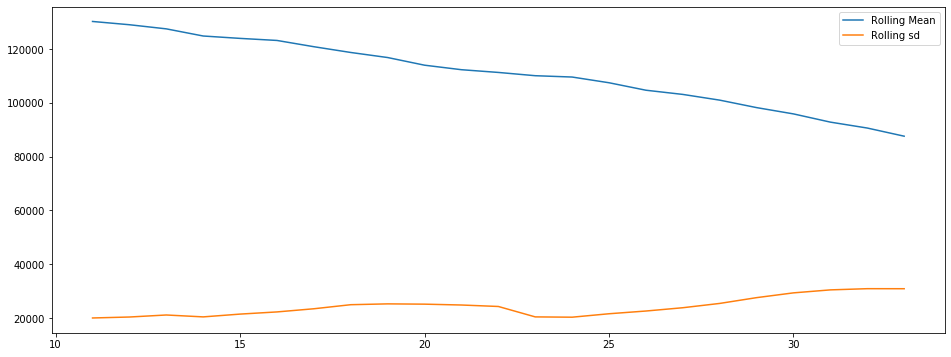

In [8]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()

**Quick observation**: There is a decreasing "Trend".

Let's now check the trend, seasonality and residuals.

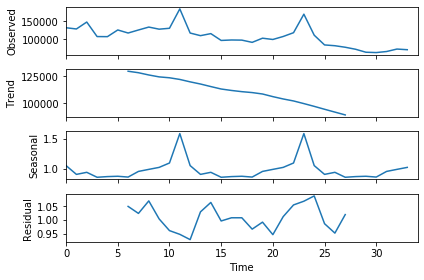

In [9]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")

fig = res.plot()

### Stationarity

Stationarity is a very important aspect of a time series, it represents that any data point is related to each other only by how far apart they are, the mean, variance and covariance of the series should not be a function of time.

Statistical models assume the time series to be stationary.

One of the famous method to check stationarity is **ADF(Augmented Dicky Fuller Test**, which is used to determine whether a unit root (a feature that can cause issues in statistical inference) is present in an autoregressive model.

In [10]:
''' A gentle function to perform ADF '''

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


### Now, let's try to remove trend

In [11]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

[]

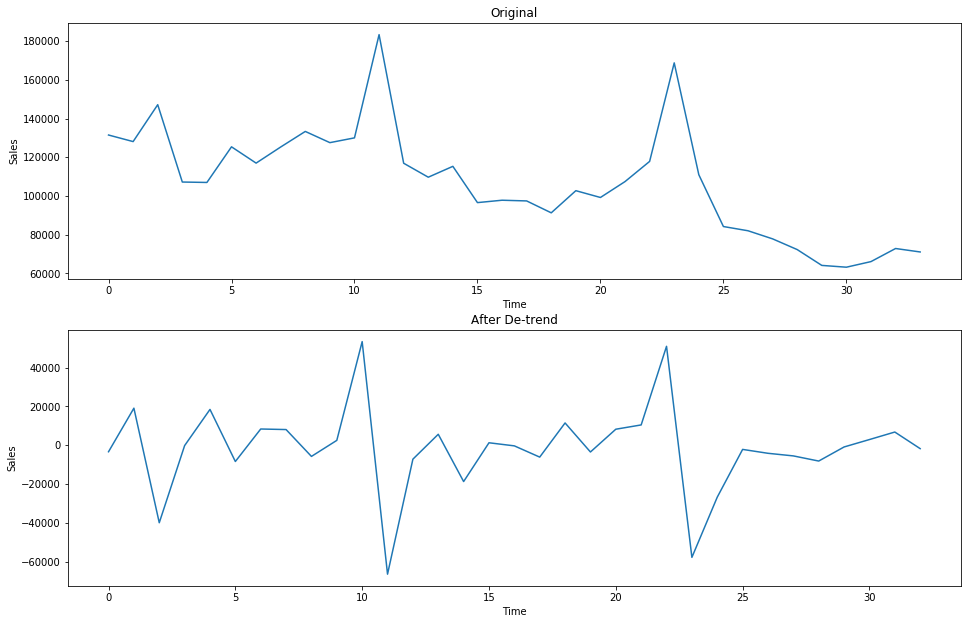

In [12]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

[]

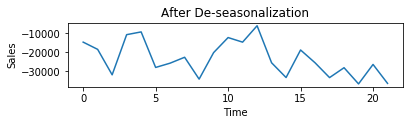

In [13]:
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')

# Assuming that the seasonality occurs in about 12 months.
new_ts = difference(ts,12)
plt.plot(new_ts)
plt.plot()

In [14]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


**Quick observation**: We may see that ou p-value is less than 5%, thus we can assume that the series is stationary. Additionaly, we can get back to the original form using the inverse_difference defined above.